Import cleaned data to start the EDA

In [4]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import warnings
import mlflow
import matplotlib.pyplot as plt
import rasterio
import geopandas as geopd
import rasterio.rio
import seaborn as sns
import datetime as dt 

from rasterio.plot import show
from scipy.spatial import ConvexHull

import pyreadr



In [5]:
foxes_all = geopd.read_file("../data/cleaned_shapefiles/foxes_all.shp")
foxes_resamp = geopd.read_file("../data/cleaned_shapefiles/foxes_resamp.shp")
#sample_points = geopd.read_file("../data/cleaned_shapefiles/sample_points.shp")


In [6]:
foxes_all.head()

,x_,y_,t_,id,sex,NDVI,NDMI,soil,veg,slope,aspect,elev,timestamp,geometry
0,548522.717454,7.353167e+06,2018-07-10-01:56:30,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,1.531181e+09,POINT (548522.717 7353166.639)
1,548525.680513,7.353168e+06,2018-07-10-06:56:32,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,1.531199e+09,POINT (548525.681 7353168.363)
2,548539.963810,7.353164e+06,2018-07-10-11:56:32,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,1.531217e+09,POINT (548539.964 7353164.150)
3,548195.507163,7.352493e+06,2018-07-10-22:31:11,2018-FSBD608-001,F,0.443307,-0.138425,Stone,Grassland,10.065748,339.629059,1072.429321,1.531255e+09,POINT (548195.507 7352493.197)
4,548558.891944,7.352589e+06,2018-07-11-13:31:01,2018-FSBD608-001,F,0.504280,-0.113833,Stone,Grassland,12.232175,6.898972,1056.955200,1.531309e+09,POINT (548558.892 7352588.648)


In [7]:
xy = np.array(foxes_all.iloc[:,0:2].to_numpy())
xy

array([[ 548522.71745433, 7353166.63935064],
       [ 548525.68051298, 7353168.36288026],
       [ 548539.96380995, 7353164.1503711 ],
       ...,
       [ 544147.65680166, 7379630.54934573],
       [ 539474.78087464, 7379241.11823726],
       [ 544191.34419221, 7377676.12694494]])

In [8]:
hull = ConvexHull(xy)
hull.coplanar

array([], shape=(0, 3), dtype=int32)

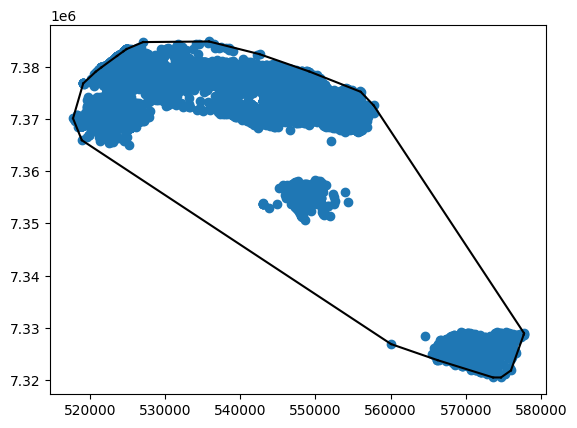

In [9]:
plt.plot(xy[:,0], xy[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(xy[simplex, 0], xy[simplex, 1], 'k-')

In [10]:
indiv_fox_all = {}
for i in foxes_all.id.unique():
    indiv_fox_all[i] = foxes_all[foxes_all.id == i]

In [11]:
fox1 = indiv_fox_all["2018-FSBD608-001"]
fox2 = indiv_fox_all["2018-FSBD615_v-gr/r-gr"]
fox3 = indiv_fox_all["2018-FSBD619_r-gr/r-y"]
fox4 = indiv_fox_all["2018-FSBD641_b-r/gr-b"]
fox5 = indiv_fox_all["2019-FSAC008-011"]
fox6 = indiv_fox_all["2019-FSAC008-012"]
fox7 = indiv_fox_all["2019-FSBD197-005"]
fox8 = indiv_fox_all["2019-FSBD609-002"]
fox9 = indiv_fox_all["2019-FSBD615-001"]
fox10 = indiv_fox_all["2019-FSBD622-006"]
fox11 = indiv_fox_all["2019-FSBD624-004"]
fox12 = indiv_fox_all["2019-FSBD641_y-gr/r-b"]


In [12]:
fox1

,x_,y_,t_,id,sex,NDVI,NDMI,soil,veg,slope,aspect,elev,timestamp,geometry
0,548522.717454,7.353167e+06,2018-07-10-01:56:30,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,1.531181e+09,POINT (548522.717 7353166.639)
1,548525.680513,7.353168e+06,2018-07-10-06:56:32,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,1.531199e+09,POINT (548525.681 7353168.363)
2,548539.963810,7.353164e+06,2018-07-10-11:56:32,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,1.531217e+09,POINT (548539.964 7353164.150)
3,548195.507163,7.352493e+06,2018-07-10-22:31:11,2018-FSBD608-001,F,0.443307,-0.138425,Stone,Grassland,10.065748,339.629059,1072.429321,1.531255e+09,POINT (548195.507 7352493.197)
4,548558.891944,7.352589e+06,2018-07-11-13:31:01,2018-FSBD608-001,F,0.504280,-0.113833,Stone,Grassland,12.232175,6.898972,1056.955200,1.531309e+09,POINT (548558.892 7352588.648)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17503,551350.466830,7.357364e+06,2019-08-19-20:18:41,2018-FSBD608-001,F,0.336520,-0.175044,Roesberg,Grassland,9.815003,26.903332,1189.074707,1.566239e+09,POINT (551350.467 7357364.364)
17508,547728.860676,7.357186e+06,2019-08-19-21:18:43,2018-FSBD608-001,F,0.558600,-0.019533,Moraine,Dry Shrub,1.752188,336.333374,961.918579,1.566242e+09,POINT (547728.861 7357186.235)
17515,548039.552990,7.353170e+06,2019-08-19-22:18:42,2018-FSBD608-001,F,0.508883,-0.084728,Moraine,Grassland,3.565104,177.626160,1023.604004,1.566246e+09,POINT (548039.553 7353170.402)
17522,546632.505080,7.354903e+06,2019-08-19-23:18:43,2018-FSBD608-001,F,0.643688,0.126031,Moraine,Grassland,0.699925,210.590652,968.545471,1.566250e+09,POINT (546632.505 7354902.761)


In [13]:
indiv_fox_all

{'2018-FSBD608-001':                   x_            y_                   t_                id sex  \
 0      548522.717454  7.353167e+06  2018-07-10-01:56:30  2018-FSBD608-001   F   
 1      548525.680513  7.353168e+06  2018-07-10-06:56:32  2018-FSBD608-001   F   
 2      548539.963810  7.353164e+06  2018-07-10-11:56:32  2018-FSBD608-001   F   
 3      548195.507163  7.352493e+06  2018-07-10-22:31:11  2018-FSBD608-001   F   
 4      548558.891944  7.352589e+06  2018-07-11-13:31:01  2018-FSBD608-001   F   
 ...              ...           ...                  ...               ...  ..   
 17503  551350.466830  7.357364e+06  2019-08-19-20:18:41  2018-FSBD608-001   F   
 17508  547728.860676  7.357186e+06  2019-08-19-21:18:43  2018-FSBD608-001   F   
 17515  548039.552990  7.353170e+06  2019-08-19-22:18:42  2018-FSBD608-001   F   
 17522  546632.505080  7.354903e+06  2019-08-19-23:18:43  2018-FSBD608-001   F   
 17529  546435.693382  7.355731e+06  2019-08-20-00:18:42  2018-FSBD608-001   F

In [14]:
foxes = list(indiv_fox_all.values())
foxes[0]

,x_,y_,t_,id,sex,NDVI,NDMI,soil,veg,slope,aspect,elev,timestamp,geometry
0,548522.717454,7.353167e+06,2018-07-10-01:56:30,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,1.531181e+09,POINT (548522.717 7353166.639)
1,548525.680513,7.353168e+06,2018-07-10-06:56:32,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,1.531199e+09,POINT (548525.681 7353168.363)
2,548539.963810,7.353164e+06,2018-07-10-11:56:32,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,205.492111,1033.016602,1.531217e+09,POINT (548539.964 7353164.150)
3,548195.507163,7.352493e+06,2018-07-10-22:31:11,2018-FSBD608-001,F,0.443307,-0.138425,Stone,Grassland,10.065748,339.629059,1072.429321,1.531255e+09,POINT (548195.507 7352493.197)
4,548558.891944,7.352589e+06,2018-07-11-13:31:01,2018-FSBD608-001,F,0.504280,-0.113833,Stone,Grassland,12.232175,6.898972,1056.955200,1.531309e+09,POINT (548558.892 7352588.648)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17503,551350.466830,7.357364e+06,2019-08-19-20:18:41,2018-FSBD608-001,F,0.336520,-0.175044,Roesberg,Grassland,9.815003,26.903332,1189.074707,1.566239e+09,POINT (551350.467 7357364.364)
17508,547728.860676,7.357186e+06,2019-08-19-21:18:43,2018-FSBD608-001,F,0.558600,-0.019533,Moraine,Dry Shrub,1.752188,336.333374,961.918579,1.566242e+09,POINT (547728.861 7357186.235)
17515,548039.552990,7.353170e+06,2019-08-19-22:18:42,2018-FSBD608-001,F,0.508883,-0.084728,Moraine,Grassland,3.565104,177.626160,1023.604004,1.566246e+09,POINT (548039.553 7353170.402)
17522,546632.505080,7.354903e+06,2019-08-19-23:18:43,2018-FSBD608-001,F,0.643688,0.126031,Moraine,Grassland,0.699925,210.590652,968.545471,1.566250e+09,POINT (546632.505 7354902.761)


### __Function Definition for Home Range plotting__

In [15]:
def homerange_plot(data, proportion = 0.95):
    
    xy = np.array(data.iloc[:,0:2].to_numpy())
    ind_list = np.linalg.norm(xy - np.mean(xy, axis = 0, keepdims=True), axis = 1).argsort()
    xy_sorted = xy[ind_list, :]

    n_drop = int(np.ceil(xy_sorted.shape[0]*(1-proportion)))
    xy_hr = xy_sorted[:-n_drop,...]
    hull = ConvexHull(xy_hr)
    
    f, ax = plt.subplots()
    ax.plot(xy[:,0], xy[:,1], 'o')
    for simplex in hull.simplices:
        ax.plot(xy_hr[simplex, 0], xy_hr[simplex, 1], 'k-')
    plt.show()

#### __Plotting the Home Ranges__

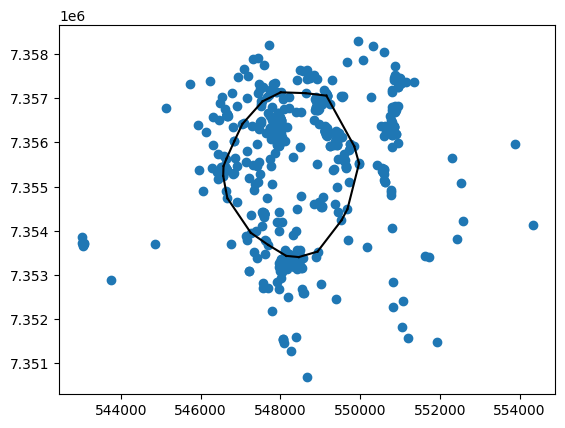

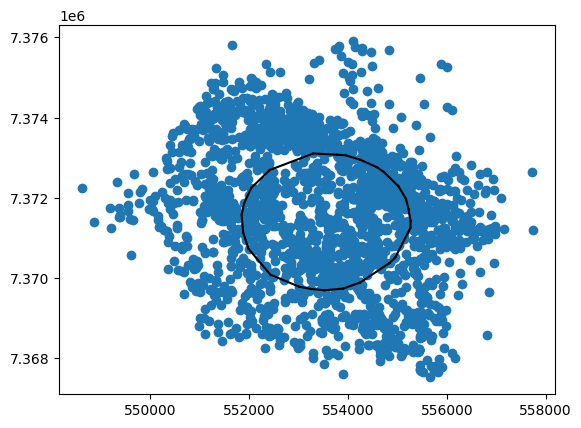

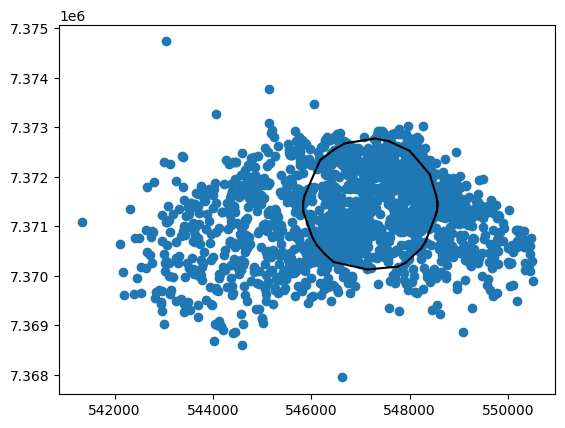

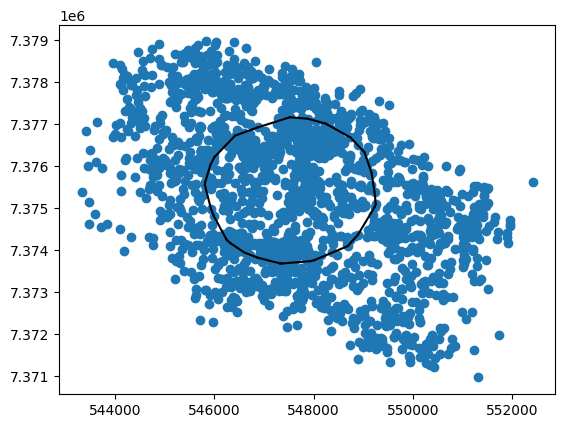

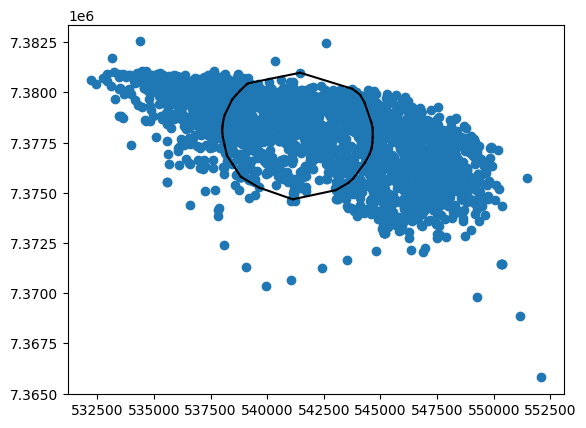

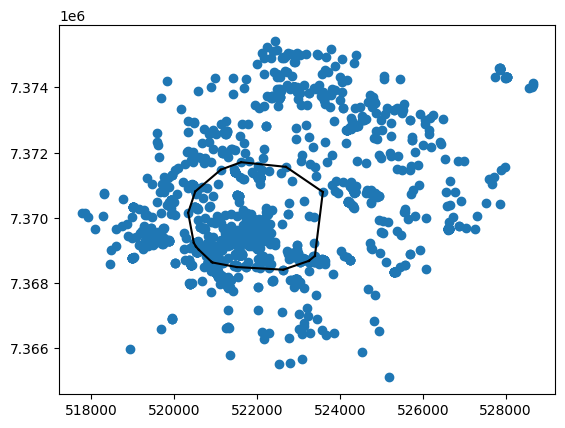

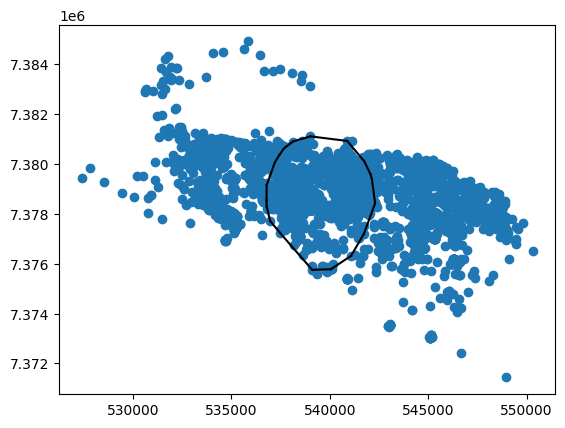

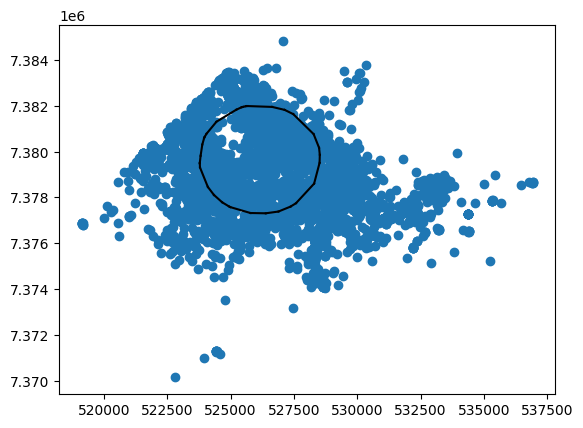

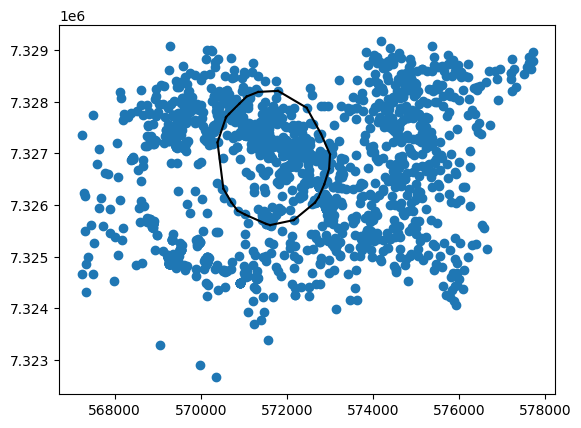

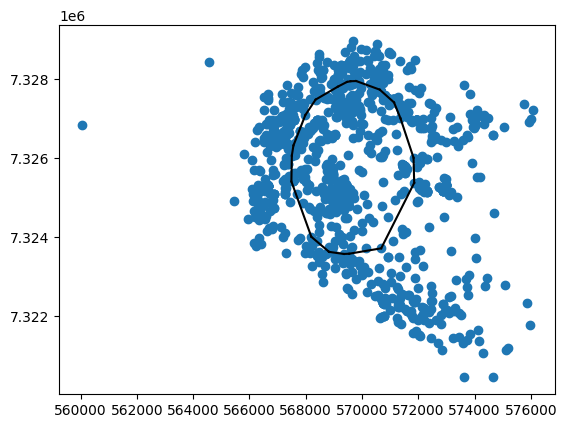

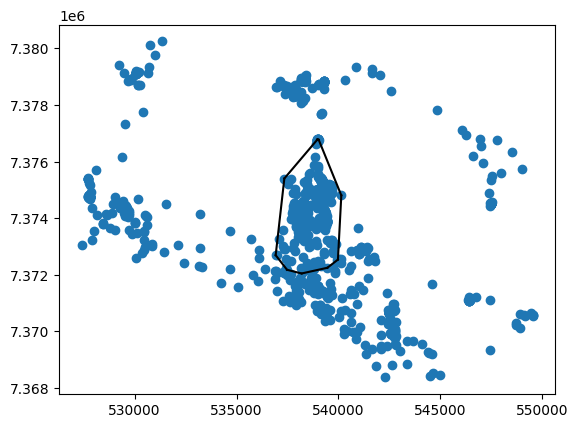

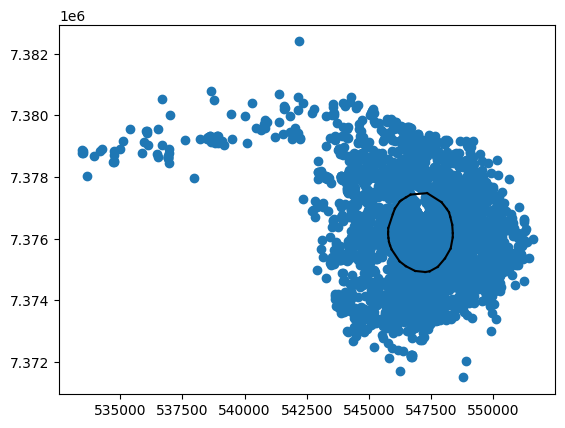

In [17]:
for i in foxes:
    homerange_plot(i, 0.5)